# Notebook

- [ ] Remove dupe imports across cells
- [X] Extra preprocessing steps (tokenization alr done in CNN/RNN models)
- [X] Run models on preprocessed data (I think we might need to use an embedding matrix)
- [x] Train base RNN 
    - precision    recall  f1-score   support

           0       0.72      0.76      0.74      9955
           1       0.55      0.44      0.49      5817
           2       0.59      0.49      0.53      8407
           3       0.59      0.47      0.52     16026
           4       0.87      0.94      0.91     73486

    accuracy                           0.80    113691
   macro avg       0.66      0.62      0.64    113691
weighted avg       0.78      0.80      0.79    113691

- [x] Train base CNN 
    - {Accuracy: 0.7964042888179363 Precision: 0.7863339732275043 Recall: 0.7964042888179363 F1 Score: 0.7883054882478613}
- [x] Port over VADER model from Kaggle   
    - {Accuracy: 0.59, Precision: 0.55, Recall: 0.59, F1 Score: 0.57}
- [x] Train logistic regression model
    - {'accuracy': 0.757500593714542, 'precision': 0.7506075118976793, 'recall': 0.757500593714542, 'f1': 0.7534493206911141}
- [x] Train constant prediction model 
    - {'accuracy': 0.07463211687820497, 'precision': 0.9309378359915171, 'recall': 0.07463211687820497, 'f1': 0.010366250519112906}


# No special preprocessing

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning

# Read dataset and store in df, check df structure
df = pd.read_csv("Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Baselines

In [2]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
# Replace NaN values with empty strings (otherwise we crash on the vectorizer)
df = df.replace(np.nan, '', regex=True)

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Set up a TF-IDF vectorizer to convert the text features into numerical features
vectorizer = TfidfVectorizer()
vectorizer.fit(train_df['Summary'] + ' ' + train_df['Text'])
X_train = vectorizer.transform(train_df['Summary'] + ' ' + train_df['Text'])
X_test = vectorizer.transform(test_df['Summary'] + ' ' + test_df['Text'])

# Scale the features
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = train_df['Score']
y_test = test_df['Score']

# Define evaluation metrics
def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# Baseline 1: Constant prediction (3 because score is between 1 to 5)
dummy = DummyClassifier(strategy='constant', constant=3)
dummy.fit(X_train, y_train)
dummy_preds = dummy.predict(X_test)
print('Dummy Classifier - Constant Prediction')
print(evaluate(y_test, dummy_preds))

# Baseline 2: Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print('Logistic Regression')
print(evaluate(y_test, lr_preds))

# Dataset shift (just changing the random state for the split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123) # change random state
X_train = vectorizer.transform(train_df['Summary'] + ' ' + train_df['Text'])
X_test = vectorizer.transform(test_df['Summary'] + ' ' + test_df['Text'])
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = train_df['Score']
y_test = test_df['Score']

# Evaluate baselines on shifted dataset
dummy_preds = dummy.predict(X_test)
print('Dummy Classifier - Constant Prediction (shifted dataset)')
print(evaluate(y_test, dummy_preds))

lr_preds = lr.predict(X_test)
print('Logistic Regression (shifted dataset)')
print(evaluate(y_test, lr_preds))

Dummy Classifier - Constant Prediction
{'accuracy': 0.07463211687820497, 'precision': 0.9309378359915171, 'recall': 0.07463211687820497, 'f1': 0.010366250519112906}
Logistic Regression
{'accuracy': 0.7573950444626224, 'precision': 0.7504314063889737, 'recall': 0.7573950444626224, 'f1': 0.753287427276215}
Dummy Classifier - Constant Prediction (shifted dataset)
{'accuracy': 0.07532698278667617, 'precision': 0.930347171549068, 'recall': 0.07532698278667617, 'f1': 0.010553356191322966}
Logistic Regression (shifted dataset)
{'accuracy': 0.8497770272053197, 'precision': 0.8440673537659681, 'recall': 0.8497770272053197, 'f1': 0.8456600877924617}


# Kaggle Submission

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


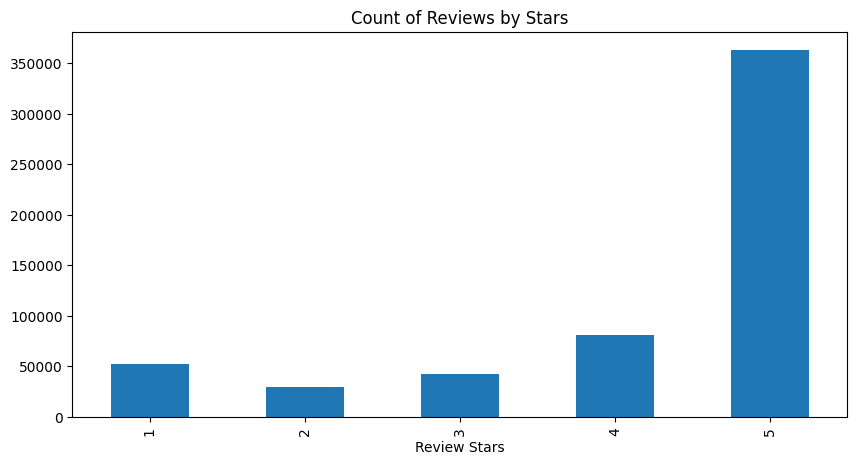

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [6]:
%pip install nltk
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
# nltk.download('vader_lexicon')

ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

sia = SentimentIntensityAnalyzer()

sia.polarity_scores('I am so happy!')

In [7]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

vaders.head()

  0%|          | 0/568454 [00:00<?, ?it/s]

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
# Convert sentiment scores to rating scores
vaders['predicted_rating'] = vaders['compound'].apply(lambda x: 1 if x <= -0.6 else
                                                      2 if -0.6 < x <= -0.2 else
                                                      3 if -0.2 < x <= 0.2 else
                                                      4 if 0.2 < x <= 0.6 else 5)

# Calculate evaluation metrics
accuracy = accuracy_score(vaders['Score'], vaders['predicted_rating'])
precision = precision_score(vaders['Score'], vaders['predicted_rating'], average='weighted')
recall = recall_score(vaders['Score'], vaders['predicted_rating'], average='weighted')
f1 = f1_score(vaders['Score'], vaders['predicted_rating'], average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.59
Precision: 0.55
Recall: 0.59
F1 Score: 0.57


In [2]:
%pip install tensorflow==2.4

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


## CNN

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# load data
data = pd.read_csv('Reviews.csv')

# preprocess
X = data['Text']
y = data['Score']
num_classes = len(np.unique(y))
y = y - 1  # convert score from 1-5 to 0-4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
# Def model
embedding_dim = 50
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
batch_size = 32
epochs = 10
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs)

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Get metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')

# metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


2023-04-24 01:00:07.634032: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-04-24 01:00:58.357980: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-24 01:00:58.365392: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-24 01:00:58.564883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 01:00:58.567817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.62GiB deviceMemoryBandwidth: 298.08GiB/s
2023-04-24 01:00:58.567860: I tensorflow/stream_executor/platform/default/dso_loade

Epoch 1/10


2023-04-24 01:01:00.780400: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-04-24 01:01:15.153170: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-04-24 01:01:15.157448: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


14212/14212 [==============================] - 866s 51ms/step - loss: 0.8072 - accuracy: 0.7052 - val_loss: 0.6431 - val_accuracy: 0.7586
Epoch 2/10
14212/14212 [==============================] - 738s 52ms/step - loss: 0.6242 - accuracy: 0.7663 - val_loss: 0.6155 - val_accuracy: 0.7735
Epoch 3/10
14212/14212 [==============================] - 739s 52ms/step - loss: 0.5653 - accuracy: 0.7902 - val_loss: 0.6143 - val_accuracy: 0.7781
Epoch 4/10
14212/14212 [==============================] - 740s 52ms/step - loss: 0.5198 - accuracy: 0.8084 - val_loss: 0.5946 - val_accuracy: 0.7882
Epoch 5/10
14212/14212 [==============================] - 739s 52ms/step - loss: 0.4834 - accuracy: 0.8220 - val_loss: 0.5981 - val_accuracy: 0.7910
Epoch 6/10
14212/14212 [==============================] - 739s 52ms/step - loss: 0.4521 - accuracy: 0.8334 - val_loss: 0.5998 - val_accuracy: 0.7951
Epoch 7/10
14212/14212 [==============================] - 738s 52ms/step - loss: 0.4258 - accuracy: 0.8428 - val_loss

## RNN

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

df = pd.read_csv('Reviews.csv')

# Preprocess text data
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['Text'].values)
X = tokenizer.texts_to_sequences(df['Text'].values)
X = pad_sequences(X, maxlen=100)
Y = pd.get_dummies(df['Score']).values #One-hot scores 
 
split = int(0.8 * len(X))
X_train = X[:split]
Y_train = Y[:split]
X_test = X[split:]
Y_test = Y[split:]

# RNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=32, input_length=100),
    tf.keras.layers.LSTM(64,use_bias=False),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=10, batch_size=32)

# Get eval metrics
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_classes, Y_pred_classes))

Epoch 1/10
14212/14212 [==============================] - 1395s 98ms/step - loss: 0.8501 - accuracy: 0.6910
Epoch 2/10
14212/14212 [==============================] - 1394s 98ms/step - loss: 0.6604 - accuracy: 0.7511
Epoch 3/10
14212/14212 [==============================] - 1392s 98ms/step - loss: 0.6031 - accuracy: 0.7753
Epoch 4/10
14212/14212 [==============================] - 1407s 99ms/step - loss: 0.5615 - accuracy: 0.7916
Epoch 5/10
14212/14212 [==============================] - 1399s 98ms/step - loss: 0.5240 - accuracy: 0.8078
Epoch 6/10
14212/14212 [==============================] - 1394s 98ms/step - loss: 0.4951 - accuracy: 0.8191
Epoch 7/10
14212/14212 [==============================] - 1393s 98ms/step - loss: 0.4674 - accuracy: 0.8305
Epoch 8/10
14212/14212 [==============================] - 1393s 98ms/step - loss: 0.4421 - accuracy: 0.8410
Epoch 9/10
14212/14212 [==============================] - 1413s 99ms/step - loss: 0.4203 - accuracy: 0.8499
Epoch 10/10
14212/14212 [===

# Preprocess data and rerun models

In [17]:
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

df = pd.read_csv("Reviews.csv")
df = df.dropna()
df = df.iloc[:100000]

# necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

def tokenize(text):
    return word_tokenize(text.lower())

def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def stem(tokens):
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(token) for token in tokens]

def generate_bigrams(tokens):
    measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokens)
    finder.apply_freq_filter(2)
    return [' '.join(bigram) for bigram in finder.nbest(measures.raw_freq, 10)]

def calculate_text_length(text):
    return len(text)

# create new columns
print('applying')
df['Tokens'] = df['Text'].apply(tokenize)
df['Lemmatized_Text'] = df['Tokens'].apply(lemmatize)
# df['Stems'] = df['Tokens'].apply(stem)
df['Bigrams'] = df['Tokens'].apply(generate_bigrams)
df['Text Length'] = df['Text'].apply(calculate_text_length)
print('Done preprocessing')


[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


applying
Done preprocessing


# CNN on Lemmatized Text

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(df['Lemmatized_Text'], df['Score'], test_size=0.2, random_state=42)

# Tokenize and pad text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# One-hot encode labels
y_train_enc = to_categorical(y_train - 1, num_classes=5)
y_test_enc = to_categorical(y_test - 1, num_classes=5)

# CNN model
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=5000, output_dim=128, input_length=max_len)(input_layer)
conv_layer1 = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer1 = GlobalMaxPooling1D()(conv_layer1)
dropout_layer = Dropout(0.2)(pooling_layer1)
output_layer = Dense(5, activation='softmax')(dropout_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train_pad, y_train_enc, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test_enc))

# Evaluate model on test set
y_pred = np.argmax(model.predict(X_test_pad), axis=-1) + 1
y_true = y_test.to_numpy()
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Epoch 1/10
2500/2500 [==============================] - 14s 5ms/step - loss: 0.9433 - accuracy: 0.6630 - val_loss: 0.7251 - val_accuracy: 0.7264
Epoch 2/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.6662 - accuracy: 0.7481 - val_loss: 0.7129 - val_accuracy: 0.7377
Epoch 3/10
2500/2500 [==============================] - 14s 5ms/step - loss: 0.5626 - accuracy: 0.7897 - val_loss: 0.7246 - val_accuracy: 0.7337
Epoch 4/10
2500/2500 [==============================] - 15s 6ms/step - loss: 0.4575 - accuracy: 0.8294 - val_loss: 0.7362 - val_accuracy: 0.7405
Epoch 5/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.3577 - accuracy: 0.8713 - val_loss: 0.8223 - val_accuracy: 0.7386
Epoch 6/10
2500/2500 [==============================] - 14s 5ms/step - loss: 0.2764 - accuracy: 0.9027 - val_loss: 0.8787 - val_accuracy: 0.7341
Epoch 7/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.2136 - accuracy: 0.9265 - val_loss: 0.9810 - val_ac

# CNN on Bigrams

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(df['Bigrams'], df['Score'], test_size=0.2, random_state=42)

# Tokenize and pad text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# One-hot encode labels
y_train_enc = to_categorical(y_train - 1, num_classes=5)
y_test_enc = to_categorical(y_test - 1, num_classes=5)

# CNN model
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=5000, output_dim=128, input_length=max_len)(input_layer)
conv_layer1 = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer1 = GlobalMaxPooling1D()(conv_layer1)
dropout_layer = Dropout(0.2)(pooling_layer1)
output_layer = Dense(5, activation='softmax')(dropout_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train_pad, y_train_enc, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test_enc))

# Evaluate model on test set
y_pred = np.argmax(model.predict(X_test_pad), axis=-1) + 1
y_true = y_test.to_numpy()
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Epoch 1/10
2500/2500 [==============================] - 13s 5ms/step - loss: 1.1438 - accuracy: 0.6231 - val_loss: 1.0999 - val_accuracy: 0.6276
Epoch 2/10
2500/2500 [==============================] - 14s 6ms/step - loss: 1.0395 - accuracy: 0.6486 - val_loss: 1.0901 - val_accuracy: 0.6294
Epoch 3/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.9563 - accuracy: 0.6793 - val_loss: 1.1155 - val_accuracy: 0.6276
Epoch 4/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.8901 - accuracy: 0.7071 - val_loss: 1.1594 - val_accuracy: 0.6253
Epoch 5/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.8179 - accuracy: 0.7310 - val_loss: 1.2343 - val_accuracy: 0.6249
Epoch 6/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.7781 - accuracy: 0.7456 - val_loss: 1.3189 - val_accuracy: 0.6280
Epoch 7/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.7390 - accuracy: 0.7602 - val_loss: 1.3962 - val_ac